In [1]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Set paths
images_folder = '/kaggle/input/ham1000-segmentation-and-classification/images'
masks_folder = '/kaggle/input/ham1000-segmentation-and-classification/masks'
csv_file = '/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv'

# Load the CSV file containing the image and label data
groundtruth_df = pd.read_csv(csv_file)

# Extract image filenames and labels
images = groundtruth_df['image'].values
labels = groundtruth_df.drop(columns=['image']).values  # Drop image_id and keep the one-hot encoded labels

image_paths = []
mask_paths = []
all_labels = []

# Loop over the image filenames and generate paths
for image_filename, label in zip(images, labels):
    # Build image and mask paths
    image_path = os.path.join(images_folder, image_filename) + '.jpg'
    mask_path = os.path.join(masks_folder, image_filename) + '_segmentation.png'
    
    # Append to the lists
    image_paths.append(image_path)
    mask_paths.append(mask_path)
    all_labels.append(list(label))  # Store the one-hot encoded label

# Create a DataFrame with the image paths, mask paths, and labels
data = {
    'image_path': image_paths,
    'mask_path': mask_paths,
    'labels': all_labels
}

data_df = pd.DataFrame(data)

# Display the first few rows of the dataframe

print(data_df.head())


                                          image_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                           mask_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                labels  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
2  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  


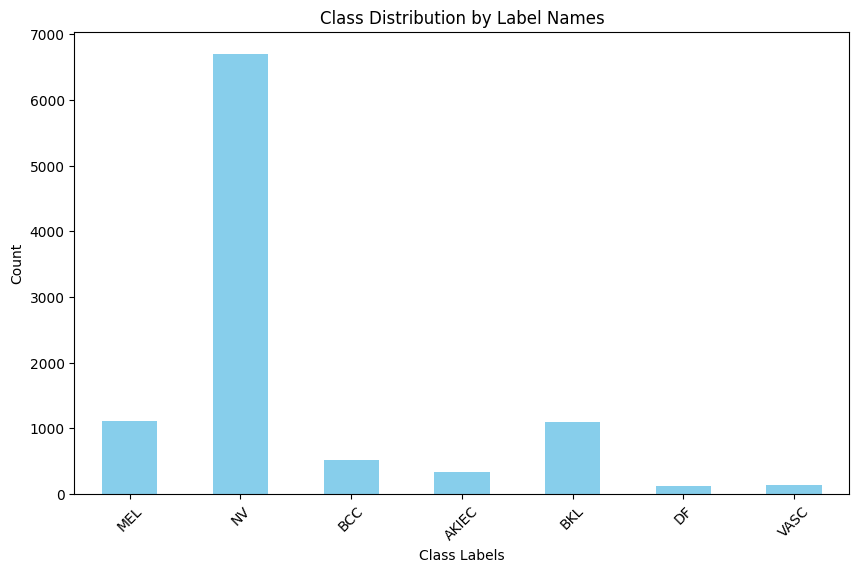

                                          image_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                           mask_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                labels  class_label  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
2  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]            0  
cl

In [3]:
class_labels_map = {
    0: 'MEL',
    1: 'NV',
    2: 'BCC',
    3: 'AKIEC',
    4: 'BKL',
    5: 'DF',
    6: 'VASC'
}

# Convert one-hot encoded labels to class indices
data_df['class_label'] = data_df['labels'].apply(lambda x: x.index(1))  # Convert one-hot to class indices

# Compute class distribution with label names
class_distribution = data_df['class_label'].value_counts().sort_index()
class_distribution.index = class_distribution.index.map(class_labels_map)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution by Label Names')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(data_df.head())
print(data_df['class_label'].value_counts())

In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        """
        Initializes the segmentation dataset.

        Args:
            image_paths (list of str): Paths to input images.
            mask_paths (list of str): Paths to corresponding masks.
            labels (list of int or str): Class labels for the masks.
            transform (callable, optional): Transformations to apply to images and masks.
        """
        self.image_paths = image_paths.tolist()
        self.mask_paths = mask_paths.tolist()
        self.labels = labels.tolist()
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Fetches a single sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing:
                - 'image': The transformed input image as a Tensor.
                - 'mask': The transformed mask as a Tensor.
                - 'label': The class label of the sample.
        """
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Ensure image is RGB
        mask = Image.open(self.mask_paths[idx])  # Assume mask is grayscale
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image,label,mask


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    data_df[['image_path', 'mask_path']],  # Features
    data_df['class_label'],  # Labels
    test_size=0.3,
    stratify=data_df['class_label'],
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    data_df[['image_path', 'mask_path']],  # Features
    data_df['class_label'],  # Labels
    test_size=0.5,
    stratify=data_df['class_label'],
    random_state=42
)

print(y_test)
print(y_val)
print(y_train)

9679    0
5243    3
9169    1
6021    1
3676    4
       ..
4632    1
1315    1
7277    1
9920    1
301     1
Name: class_label, Length: 5007, dtype: int64
630     1
8534    0
3947    1
2545    1
8998    0
       ..
5480    1
746     1
1694    1
9025    1
3296    1
Name: class_label, Length: 5008, dtype: int64
7107    2
3367    0
8698    0
4288    1
6172    1
       ..
6815    1
3534    1
5803    1
1014    1
4986    1
Name: class_label, Length: 7010, dtype: int64


In [6]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
# Dataset and DataLoader
train_dataset = SegmentationDataset(X_train['image_path'],X_train['mask_path'].values, y_train, transform=train_transform)
val_dataset = SegmentationDataset(X_val['image_path'],X_val['mask_path'].values, y_val, transform=test_transform)
test_dataset = SegmentationDataset(X_test['image_path'], X_test['mask_path'].values, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # Encoder: ResNet-34 without fully connected layers
        self.encoder = models.resnet34(pretrained=True)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC layers

        # Decoder: Use multiple ConvTranspose2d layers for upsampling
        self.decoder1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsample to 14x14
        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsample to 28x28
        self.decoder3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # Upsample to 56x56
        self.decoder4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)    # Upsample to 112x112
        self.decoder5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)    # Upsample to 224x224

        # Final convolution for classification
        self.classifier = nn.Conv2d(16, num_classes, kernel_size=1)  # Output classes

    def forward(self, x):
        # Encoder (ResNet-34)
        enc = self.encoder(x)  # Shape: [batch_size, 512, 7, 7]

        # Decoder: Upsampling through ConvTranspose2d layers
        dec1 = self.decoder1(enc)  # Shape: [batch_size, 256, 14, 14]
        dec2 = self.decoder2(dec1)  # Shape: [batch_size, 128, 28, 28]
        dec3 = self.decoder3(dec2)  # Shape: [batch_size, 64, 56, 56]
        dec4 = self.decoder4(dec3)  # Shape: [batch_size, 32, 112, 112]
        dec5 = self.decoder5(dec4)  # Shape: [batch_size, 16, 224, 224]
        
        # Final classification
        output = self.classifier(dec5)  # Shape: [batch_size, num_classes, 224, 224]
        return output

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 220MB/s]


Epoch 1/10, Loss: 0.3098, Train Accuracy: 0.8711, Val Accuracy: 0.8791, Val Loss: 0.3056
Epoch 2/10, Loss: 0.3053, Train Accuracy: 0.8730, Val Accuracy: 0.8824, Val Loss: 0.2938
Epoch 3/10, Loss: 0.2985, Train Accuracy: 0.8757, Val Accuracy: 0.8864, Val Loss: 0.2869
Epoch 4/10, Loss: 0.2974, Train Accuracy: 0.8763, Val Accuracy: 0.8794, Val Loss: 0.2926
Epoch 5/10, Loss: 0.2961, Train Accuracy: 0.8773, Val Accuracy: 0.8849, Val Loss: 0.2834
Epoch 6/10, Loss: 0.2942, Train Accuracy: 0.8783, Val Accuracy: 0.8843, Val Loss: 0.2839
Epoch 7/10, Loss: 0.2900, Train Accuracy: 0.8785, Val Accuracy: 0.8863, Val Loss: 0.2826
Epoch 8/10, Loss: 0.2919, Train Accuracy: 0.8775, Val Accuracy: 0.8869, Val Loss: 0.2793
Epoch 9/10, Loss: 0.2892, Train Accuracy: 0.8787, Val Accuracy: 0.8816, Val Loss: 0.2841
Epoch 10/10, Loss: 0.2875, Train Accuracy: 0.8792, Val Accuracy: 0.8881, Val Loss: 0.2819
Best Validation Accuracy: 0.8881


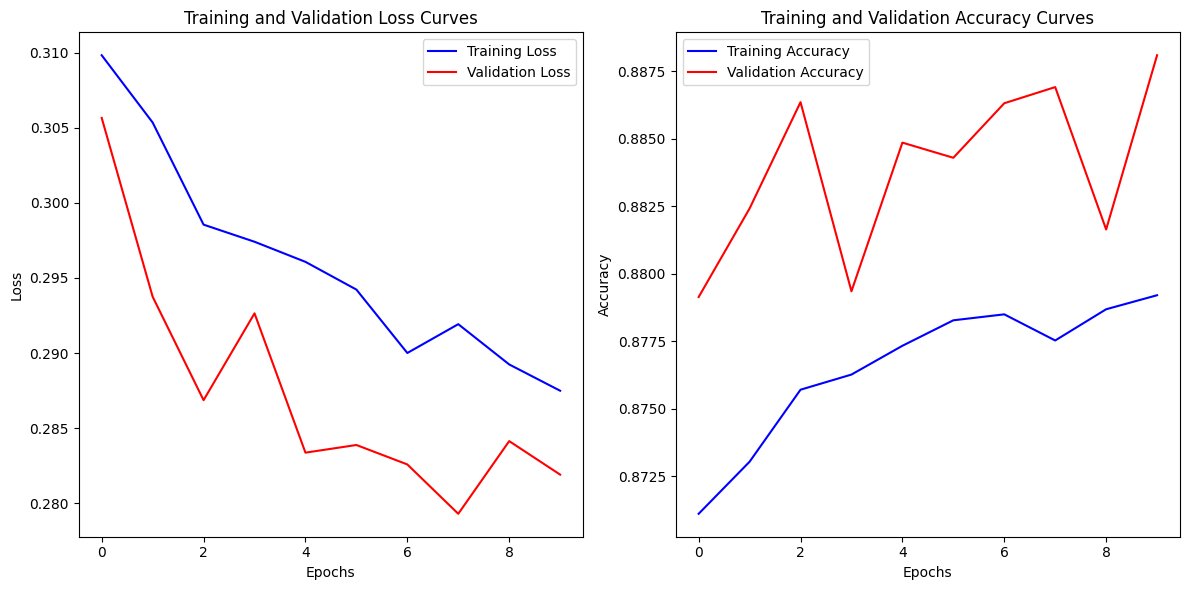

In [10]:
## import matplotlib.pyplot as plt


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    best_acc = 0.0
    train_losses = []
    val_losses = []  # To track validation losses
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training phase
        for images,label,masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1)  # Remove the single channel dimension, now shape [batch_size, height, width]

            optimizer.zero_grad()
            outputs = model(images)  # Output is of shape [batch_size, num_classes, height, width]
            
            loss = criterion(outputs, masks.long()) # Compute loss for segmentation (cross-entropy)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Compute training accuracy (pixel-wise)
            _, predicted = torch.max(outputs, 1)  # Predicted class for each pixel
            total_train += masks.numel()  # Total number of pixels
            correct_train += (predicted == masks).sum().item()  # Correctly predicted pixels

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train  # Pixel-wise training accuracy

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0  # To accumulate validation loss
        
        with torch.no_grad():
            for images,label,masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = masks.squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks.long()) # Validation loss
                val_loss += loss.item() * images.size(0)
                
                # Compute validation accuracy (pixel-wise)
                _, predicted = torch.max(outputs, 1)  # Predicted class for each pixel
                total_val += masks.numel()  # Total number of pixels
                correct_val += (predicted == masks).sum().item()  # Correctly predicted pixels

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val  # Pixel-wise validation accuracy

        # Store values for plotting
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)  # Store validation loss
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print training and validation accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
        
        best_acc = max(best_acc, val_acc)
    
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    # Plotting the Loss and Accuracy Curves
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()

    # Plot Training and Validation Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `model`, `train_loader`, `val_loader`, `criterion`, and `optimizer` are defined
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda')


In [13]:
# Validation

model.eval()
val_loss = 0
with torch.no_grad():
    for images,label,masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)
        outputs = model(images)
        val_loss += criterion(outputs, masks.long()).item()

print(f"test Loss: {val_loss / len(test_loader)}")

test Loss: 0.2780087337752057


In [14]:
def calculate_iou(preds, labels):
    intersection = (preds & labels).sum((1, 2))
    union = (preds | labels).sum((1, 2))
    return (intersection / union).mean()

def dice_coefficient(preds, labels):
    intersection = (preds * labels).sum((1, 2))
    return (2. * intersection / (preds.sum((1, 2)) + labels.sum((1, 2)))).mean()

In [16]:
# Testing using IoU and Dice Coefficient

model.eval()
test_iou, test_dice = 0, 0
with torch.no_grad():
    for images,label,masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        test_iou += calculate_iou(preds, masks.long())
        test_dice += dice_coefficient(preds, masks.long())

print(f"Test IoU: {test_iou / len(test_loader)}, Dice: {test_dice / len(test_loader)}")

Test IoU: 0.7105281352996826, Dice: 0.8103578686714172


****BONUS****

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models
import os

# Enable CUDA Launch Blocking for better error debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

class MultiTaskModel(nn.Module):
    def __init__(self, num_classes, num_segmentation_classes):
        super(MultiTaskModel, self).__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove FC layers
        
        # Classification head
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        
        # Segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_segmentation_classes, kernel_size=1)
        )
        
        # Upsample the segmentation logits to match input image size (224x224)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
    
    def forward(self, x):
        features = self.backbone(x)
        
        # Classification
        class_logits = self.classification_head(features)
        
        # Segmentation (before upsampling)
        segmentation_logits = self.segmentation_head(features)
        
        # Upsample segmentation logits to match image size
        segmentation_logits = self.upsample(segmentation_logits)
        
        return class_logits, segmentation_logits

# Initialize model
num_classes = 7  # For classification (e.g., 3 categories)
num_segmentation_classes = 7  # For segmentation (e.g., 4 labels including background)
model = MultiTaskModel(num_classes, num_segmentation_classes)

# Check if GPU is available
device = torch.device("cpu")
print("Using device:", device)
model = model.to(device)  # Move model to device

# Example inputs
batch_size = 8
image_tensor = torch.randn(batch_size, 3, 224, 224).to(device).float()  # Random images on device
classification_labels = torch.randint(0, num_classes-1, (batch_size,)).to(device).long()  # Random class labels on device
segmentation_masks = torch.randint(0, num_segmentation_classes-1, (batch_size, 224, 224)).to(device).long()  # Random masks on device

# Debugging: Print min and max values of labels and masks
print("Classification Labels Min/Max:", classification_labels.min(), classification_labels.max())
print("Segmentation Masks Min/Max:", segmentation_masks.min(), segmentation_masks.max())

# Pass data through the model
class_logits, segmentation_logits = model(image_tensor)

# Debugging: Print the shapes of the outputs
print("Class Logits Shape:", class_logits.shape)  # [8, num_classes]
print("Segmentation Logits Shape:", segmentation_logits.shape)  # [8, num_segmentation_classes, 224, 224]

# Define loss functions
classification_loss_fn = nn.CrossEntropyLoss()
segmentation_loss_fn = nn.CrossEntropyLoss()

# Compute losses
classification_loss = classification_loss_fn(class_logits, classification_labels)
segmentation_loss = segmentation_loss_fn(segmentation_logits, segmentation_masks)
total_loss = classification_loss + segmentation_loss

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    for images, labels, masks in train_loader:  # Assume train_loader is defined
        # Move data to GPU if available
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        masks = masks.squeeze(1)
        
        # Forward pass
        class_logits, segmentation_logits = model(images)
        
        # Compute losses
        classification_loss = classification_loss_fn(class_logits, labels)
        segmentation_loss = segmentation_loss_fn(segmentation_logits, masks.long())
        total_loss = classification_loss + segmentation_loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}")


Using device: cpu
Classification Labels Min/Max: tensor(0) tensor(5)
Segmentation Masks Min/Max: tensor(0) tensor(5)
Class Logits Shape: torch.Size([8, 7])
Segmentation Logits Shape: torch.Size([8, 7, 224, 224])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
# classification_loss_fn = nn.CrossEntropyLoss()
# classification_loss = classification_loss_fn(class_logits, classification_labels)
# segmentation_loss_fn = nn.CrossEntropyLoss()
# segmentation_loss = segmentation_loss_fn(segmentation_logits, segmentation_masks)
# total_loss = classification_loss + segmentation_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# for epoch in range(10):
#     for images, labels, masks in train_loader:
#         # Move data to GPU if available
#         images, labels, masks = images.cuda(), labels.cuda(), masks.cuda()
        
#         # Forward pass
#         class_logits, segmentation_logits = model(images)
        
#         # Compute losses
#         classification_loss = classification_loss_fn(class_logits, labels)
#         segmentation_loss = segmentation_loss_fn(segmentation_logits, masks)
#         total_loss = classification_loss + segmentation_loss
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}")


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same